# Test energy loss updates

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import arviz

import sys
sys.path.append("../../../../fancy")


from fancy.interfaces.data import Data
from fancy.interfaces.stan import Model
from fancy.analysis import Analysis
from fancy.propagation.energy_loss import EnergyLoss

In [6]:
source_type = "SBG_23"
detector_type = "TA2015"
model_type = "joint"
ptype = "N"
random_seed = 42
gmf = "None"

stan_path = "../../stan/"
source_file = "../../data/sourcedata.h5"
uhecr_file = "../../data/UHECRdata.h5"

output_file = (
    "output/"
    + f"test_{model_type}_fit_{source_type}_{detector_type}_{gmf}_{ptype}_{random_seed}.h5"
)

In [7]:
if detector_type == "TA2015":
    from fancy.detector.TA2015 import detector_properties, alpha_T, M, Eth
elif detector_type == "auger2014":
    from fancy.detector.auger2014 import detector_properties, alpha_T, M, Eth
elif detector_type == "auger2010":
    from fancy.detector.auger2010 import detector_properties, alpha_T, M, Eth
else:
    raise Exception("Unknown detector type!")

Test table calculation

In [8]:
data = Data()
data.add_source(source_file, source_type)  
data.add_detector(detector_properties) 

In [9]:
if model_type == "arrival":
    model_fname = stan_path + "arrival_direction_model.stan"
    summary = b"Fit of the arrival direction model to data"
elif model_type == "joint":
    model_fname = stan_path + "joint_model_tightB.stan"
    summary = b"Fit of the joint model to data"
elif model_type == "joint_gmf":
    model_fname = stan_path + "joint_gmf_model_tightB.stan"
    summary = b"Fit of the joint + GMF model to data"
else:
    raise Exception(f"Undefined model type {model_type}")

model = Model(model_filename=model_fname, include_paths=stan_path)
model.compile()
model.input(Eth=Eth, ptype=ptype)  # EeV

In [10]:
table_file = "output/test_table_{0}_{1}".format(source_type, detector_type)

summary = b'Precomputation for tables'
analysis = Analysis(data, model, analysis_type = 'joint', 
                    filename = table_file, summary = summary, energy_loss_approx="loss_length")

print("Evaluating Exposure Integral...")
analysis.build_tables(fit_only = True)
analysis.tables.save(table_file)

print("Evaluating Arrival Energies...")
analysis.build_energy_table(table_file=table_file, parallel=True)

Evaluating Exposure Integral...


Precomputing exposure integral: 100%|██████████| 23/23 [01:18<00:00,  3.41s/it]



Evaluating Arrival Energies...


Precomputing energy grids: 100%|██████████| 23/23 [01:47<00:00,  4.66s/it]


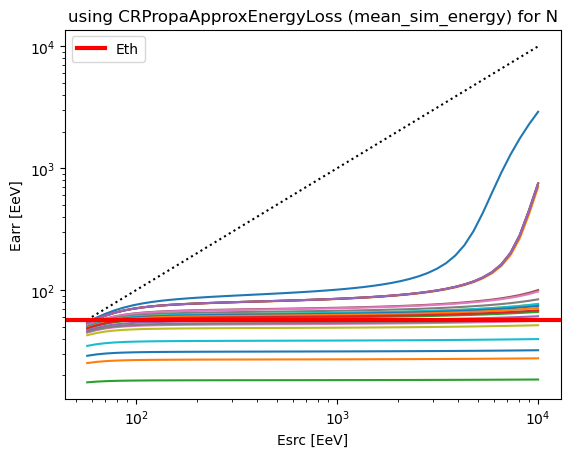

In [11]:
fig, ax = plt.subplots()
for Earr_g in analysis.Earr_grid:
    ax.plot(analysis.E_grid, Earr_g)
ax.plot(analysis.E_grid, analysis.E_grid, color="k", linestyle=":")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Esrc [EeV]")
ax.set_ylabel("Earr [EeV]")
ax.set_title("using CRPropaApproxEnergyLoss (mean_sim_energy) for N")
ax.axhline(Eth, color="red", lw=3, label="Eth")
ax.legend()
#fig.savefig("figures/stan_tables_silicon_mean_sim_energy.pdf")

In [15]:
analysis.Eth_src

array([   61.00818428,    62.70450687,    62.7078553 ,    62.7078553 ,
          62.7078553 ,    67.05017886,    69.93437478,    73.68892839,
          73.70527978,    73.70527978,    78.79884799,    86.6832679 ,
         100.98284872,   101.09139993,  1991.36216684,  7019.26226006,
       10000.        , 10000.        , 10000.        , 10000.        ,
       10000.        , 10000.        , 10000.        ])

Test fit

In [16]:
data = Data()
data.add_source(source_file, source_type)  
data.add_uhecr(uhecr_file, detector_type, ptype=ptype)
data.add_detector(detector_properties) 

model = Model(model_filename=model_fname, include_paths=stan_path)

model.compile()
model.input(Eth=Eth, ptype=ptype)  # EeV

13:57:11 - cmdstanpy - INFO - compiling stan file /home/iwsatlas1/capel/projects/uhecr_model_ta/uhecr_model/stan/joint_model_tightB.stan to exe file /home/iwsatlas1/capel/projects/uhecr_model_ta/uhecr_model/stan/joint_model_tightB
13:57:40 - cmdstanpy - INFO - compiled model executable: /home/iwsatlas1/capel/projects/uhecr_model_ta/uhecr_model/stan/joint_model_tightB
13:57:40 - cmdstanpy - WARNING - Stan compiler has produced 5 warnings:
13:57:40 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc --include-paths=/home/iwsatlas1/capel/projects/uhecr_model_ta/uhecr_model/stan --o=/home/iwsatlas1/capel/projects/uhecr_model_ta/uhecr_model/stan/joint_model_tightB.hpp /home/iwsatlas1/capel/projects/uhecr_model_ta/uhecr_model/stan/joint_model_tightB.stan
Warning in '/home/iwsatlas1/capel/projects/uhecr_model_ta/uhecr_model/stan/uhecr_propagation.stan', line 174, column 23, included from
'/home/iwsatlas1/capel/projects/uhecr_model_ta/uhecr_model/stan/joint_model_tigh

In [17]:
analysis = Analysis(
    data,
    model,
    analysis_type=model_type,
    filename=output_file,
    summary=summary,
)

analysis.use_tables(table_file)

# Fit the Stan model
fit = analysis.fit_model(chains=8, iterations=500, seed=random_seed)

# Save to analysis file
analysis.save()

13:57:56 - cmdstanpy - INFO - CmdStan start processing


Performing fitting...


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 5 |          | 00:00 Status

chain 6 |          | 00:00 Status

chain 7 |          | 00:00 Status

chain 8 |          | 00:00 Status

13:58:43 - cmdstanpy - INFO - CmdStan done processing.
13:58:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: joint_model_tightB_model_namespace::log_prob: f is -nan, but must be greater than or equal to 0.000000 (in '/home/iwsatlas1/capel/projects/uhecr_model_ta/uhecr_model/stan/joint_model_tightB.stan', line 103, column 2 to column 27)
Exception: joint_model_tightB_model_namespace::log_prob: f is -nan, but must be greater than or equal to 0.000000 (in '/home/iwsatlas1/capel/projects/uhecr_model_ta/uhecr_model/stan/joint_model_tightB.stan', line 103, column 2 to column 27)
Exception: joint_model_tightB_model_namespace::log_prob: f is -nan, but must be greater than or equal to 0.000000 (in '/home/iwsatlas1/capel/projects/uhecr_model_ta/uhecr_model/stan/joint_model_tightB.stan', line 103, column 2 to column 27)
Exception: joint_model_tightB_model_namespace::log_prob: f is -nan, but must be greater than or equal to 0.000000 (in '/home/iwsatlas1/capel/projects/uhecr_


Checking all diagnostics...
Done!


In [18]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,37.45870,0.205140,7.117890,25.22010,37.66340,49.00130,1203.93,10.9344,1.004600
Q,2.15773,0.008559,0.539329,1.35826,2.11559,3.13526,3970.80,36.0637,1.000330
F0,46.82390,0.167443,12.516600,28.05340,46.01700,68.76750,5587.82,50.7499,0.999185
B,4.98874,0.014489,1.028770,3.44511,4.92743,6.78483,5041.26,45.7860,0.999819
alpha,5.54559,0.018182,0.888919,4.23265,5.46321,7.14085,2390.16,21.7080,1.000560
...,...,...,...,...,...,...,...,...,...
lambda[68],21.44270,0.112140,7.091280,1.00000,24.00000,24.00000,3998.79,36.3180,0.999602
lambda[69],22.48600,0.093319,5.667080,1.00000,24.00000,24.00000,3687.93,33.4947,1.000060
lambda[70],8.90700,0.137718,8.560650,2.00000,6.00000,24.00000,3863.97,35.0935,1.000840


In [19]:
#fit.diagnose()

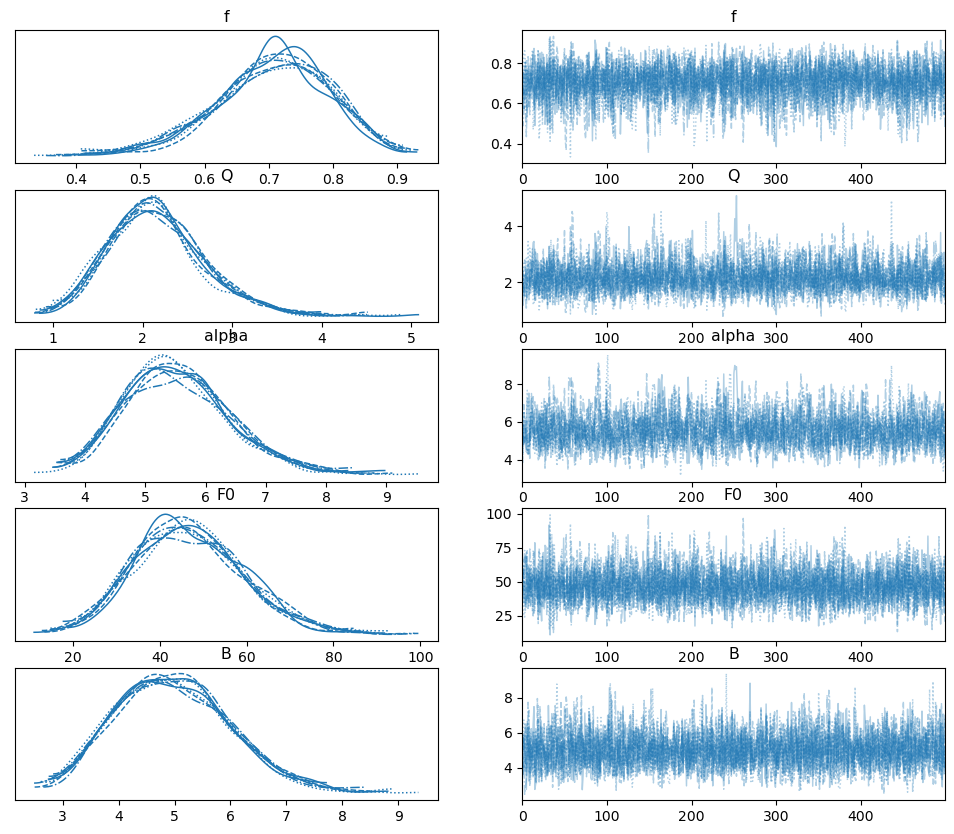

In [20]:
arviz.plot_trace(fit, var_names=["f", "Q", "alpha", "F0", "B"]);

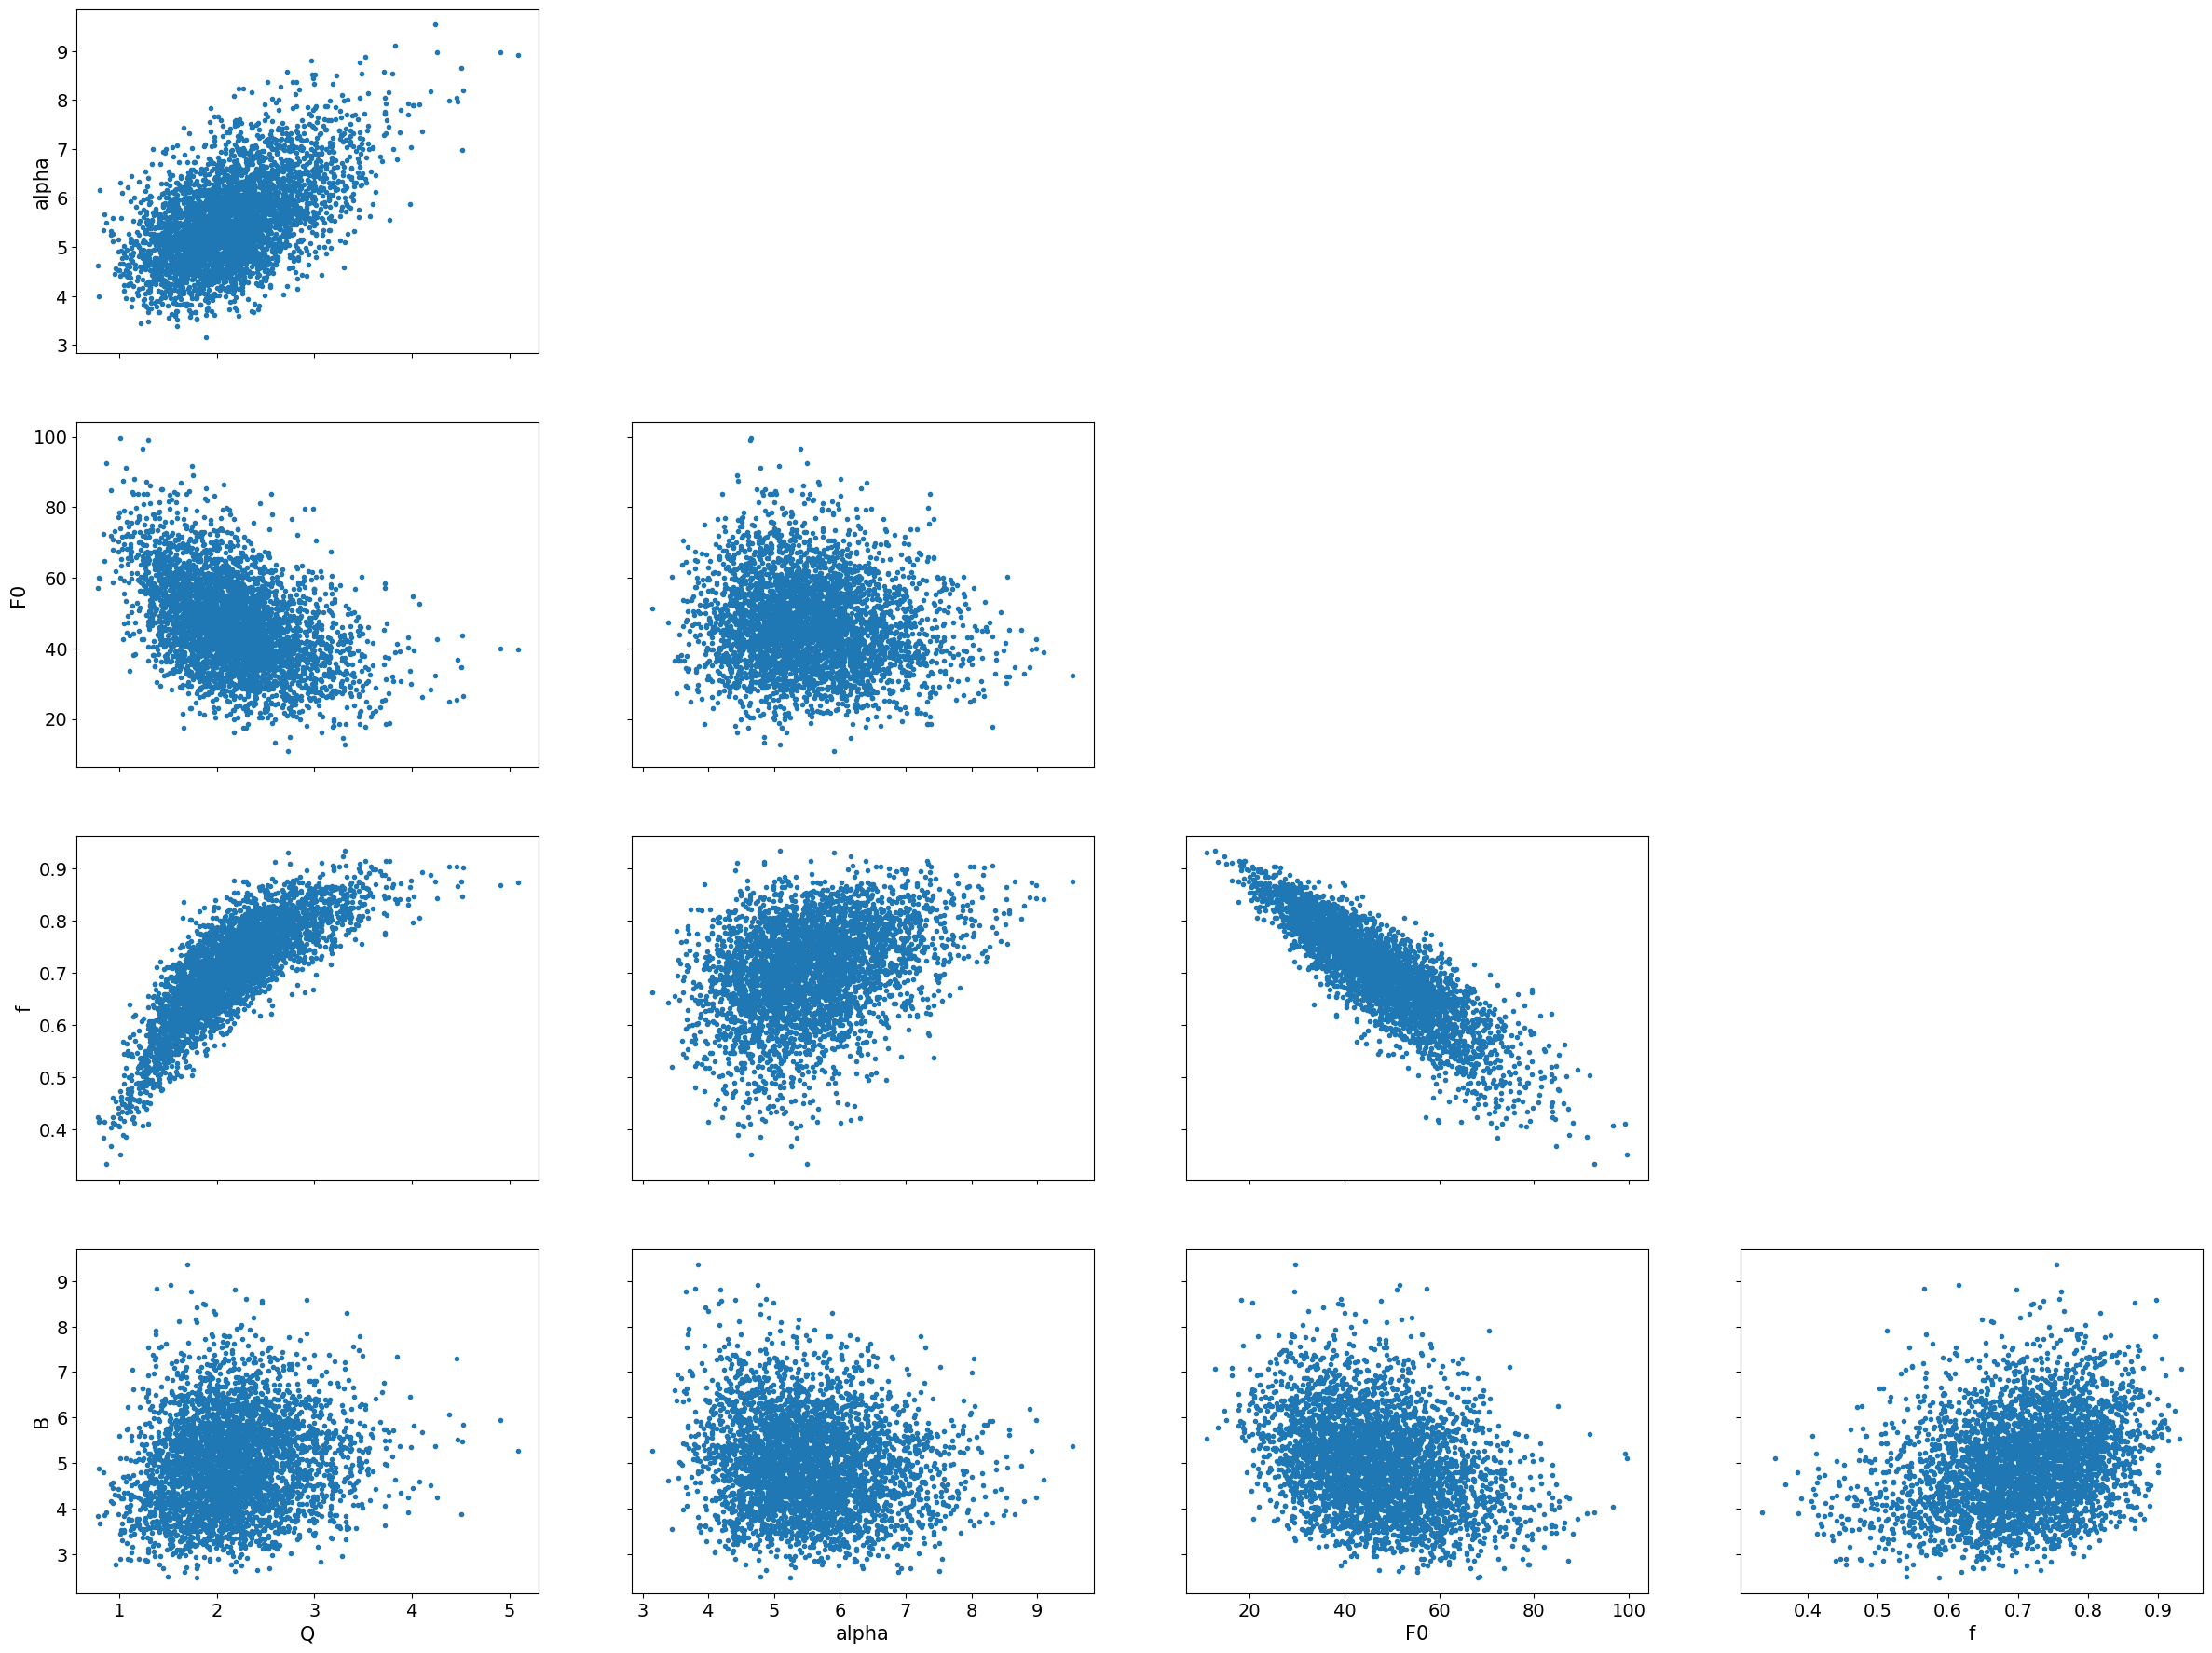

In [21]:
arviz.plot_pair(fit, var_names=["Q", "alpha", "F0", "f", "B"]);

In [22]:
min(fit.stan_variable("alpha"))

3.14918

In [23]:
log_prob = fit.method_variables()["lp__"].T

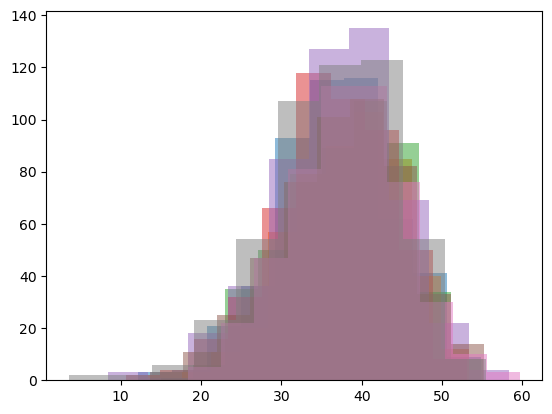

In [21]:
fig, ax = plt.subplots()
for i, lp in enumerate(log_prob):
    ax.hist(lp, alpha=0.5, label="chain " + str(i));

In [22]:
analysis.data.uhecr.energy

array([ 88.8,  82.6, 101.4,  57.3, 120.3, 139. ,  76.9, 122.2,  68.8,
        69.1,  79.3,  59.2,  59.7,  57.9,  64.2,  80.7,  75. ,  64.5,
        64.2,  62.5, 154.3,  59.5,  65.2,  61.7,  66.5,  64. ,  57.6,
        61.2,  63.7,  65.2,  58. ,  92.2,  67.1,  68.9,  93.5,  60.5,
        66.3, 162.2,  67.4, 124.8, 135.5,  74.7,  65.4,  73.9,  62.3,
        61.2,  89.3,  69.2,  83.3,  63.3,  78.8,  72.6,  78.7,  57.6,
        72.9,  81.6,  57.4,  91.8,  60.3, 101. ,  76.9,  75.6,  57.8,
        59. ,  57.4,  60.5,  68.2,  98.5, 106.8,  66.8,  62.5,  68.5])

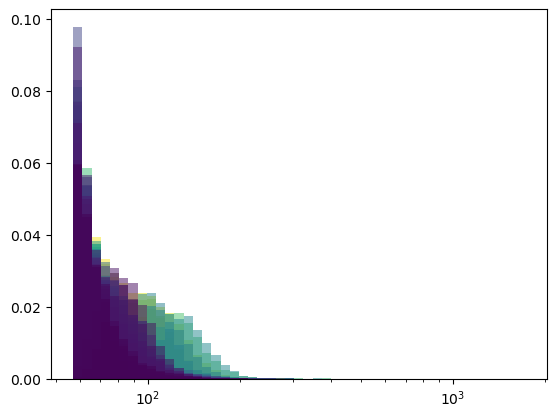

In [23]:
E = fit.stan_variable("E").T
bins = np.geomspace(np.min(E), np.max(E))
start = 0
stop = -1
N = len(data.uhecr.energy[start:stop])
colors = plt.cm.viridis_r(np.linspace(0, 1, N))
fig, ax = plt.subplots()

for i, E_uhecr in enumerate(E[start:stop]):
    ax.hist(E_uhecr, bins=bins, density=True, alpha=0.5, color=colors[i])
    #ax.axvline(analysis.data.uhecr.energy[i], color=colors[i])
ax.set_xscale("log")